# Arabic 100k Reviews (Part 1): Preprocessing

## Overview

This notebook is the first part of a comprehensive end-to-end **Natural Language Processing (NLP) pipeline** for Arabic text classification. In this part, we focus on the foundational steps that transform raw Arabic text data into a clean, analyzed dataset ready for machine learning.

## Learning Objectives

By the end of this lab, you will be able to:

1. **Acquire and extract text data** from external sources (Kaggle datasets)
2. **Apply Arabic-specific preprocessing techniques** including:
   - Text cleaning (removing URLs, handles, hashtags)
   - Normalization (removing Arabic elongations and diacritics)
   - Tokenization (breaking text into tokens)
   - Stemming (reducing words to root forms)
   - Stop word removal
3. **Understand the importance of preprocessing order** and why it matters
4. **Perform Exploratory Data Analysis (EDA)** on text data to understand:
   - Class distribution
   - Text length distributions
   - Language detection
   - Vocabulary analysis
   - Word frequency patterns by class
5. **Recognize preprocessing trade-offs** (speed vs. accuracy, information loss vs. efficiency)
6. **Use appropriate tools** for Arabic NLP (PyArabic, NLTK, Qalsadi, CAMeL Tools)

An **NLP pipeline** (as introduced in Module 1) is a systematic sequence of steps that transforms raw text into a format suitable for machine learning models.

**Later, in Part 2:** the goal is to build a model that can classify Arabic reviews into **Positive** or **Negative** sentiment.

---

> In short, we learn: What to do, how to do it, why do it, and where (order).

## Outline

1. **Setup and Imports** - Installing dependencies and importing libraries
2. **Data Acquisition** - Downloading and extracting the Arabic 100k Reviews dataset from Kaggle
3. **Data Loading** - Loading the dataset into a pandas DataFrame
4. **Exploratory Data Analysis (EDA)**:
   - Class distribution analysis
   - Text length distributions
   - Language detection
   - Vocabulary analysis
   - Word frequency patterns by class
5. **Preprocessing Pipeline**:
   - Text cleaning (URLs, handles, hashtags)
   - Normalization (Arabic elongations, diacritics)
   - Tokenization
   - Stemming/Lemmatization
   - Stop word removal
6. **Preprocessing Order** - Understanding why order matters
7. **Preprocessed Data** - Saving cleaned data for Part 2 (classification)

## References

- [NLP Pipeline, Ali Alameer | GitHub](https://github.com/Ali-Alameer/NLP/blob/main/week2_pipeline_part1.ipynb)
- [NLP_Getting_started(Preprocessing), Ali H. El-Kassas | Kaggle](https://www.kaggle.com/code/ali01lulu/03-nlp-getting-started-preprocessing/notebook)

## Glossary of Terms

**Corpus** (plural: corpora): A collection of text documents used for linguistic analysis or training NLP models. In this lab, our corpus is the Arabic reviews dataset.

**Tokenization**: The process of breaking text into smaller units called tokens (words, subwords, or characters). As you learned in Module 1, tokenization is a fundamental step in the NLP pipeline.

**Stemming**: A rule-based technique that reduces words to their root or stem form by removing prefixes and suffixes. For example, "running", "runs", "ran" → "run". Faster but less accurate than lemmatization.

**Lemmatization**: A dictionary-based technique that converts words to their base form (lemma) using linguistic knowledge. More accurate than stemming but slower. For example, "better" → "good" (stemming might not catch this).

**Stop Words**: Common words that appear frequently but carry little semantic meaning (e.g., "the", "is", "at" in English; "في", "من", "إلى" in Arabic). Removing them can reduce vocabulary size and computational overhead.

**Normalization**: The process of converting text to a standard form. This includes case folding (lowercase), removing diacritics (in Arabic), and handling elongations.

**Vocabulary**: The set of unique tokens (words) in a corpus. Building a vocabulary is essential for converting text to numerical representations.

**Data Leakage**: When information from the test set inadvertently influences the training process. We prevent this by splitting data before preprocessing.

**Exploratory Data Analysis (EDA)**: The process of analyzing datasets to summarize their main characteristics, often using visual methods. In NLP, this includes examining class distributions, text lengths, and word frequencies.

**Preprocessing Pipeline**: A sequence of preprocessing steps applied in a specific order. The order matters because later steps depend on earlier ones.

---


## Setup and Imports

We begin by installing necessary packages and importing all required libraries. Grouping imports at the top makes dependencies clear and follows Python best practices.


### Import Libraries

We group imports by category:

1. **Standard Library**: Python built-in modules
2. **Data Science**: NumPy, Pandas for data manipulation
3. **Machine Learning**: Scikit-learn for data splitting and preprocessing
4. **Visualization**: For EDA plots
5. **NLP Libraries**: Arabic-specific and general NLP tools
   - [**PyArabic**](https://github.com/linuxscout/pyarabic): Arabic text manipulation (removing diacritics, elongations)
   - [**tnkeeh (تنقيح)**](https://github.com/ARBML/tnkeeh) is an Arabic preprocessing library based on regex.
   - [**nltk**](https://www.nltk.org/): Natural Language Toolkit (stop words, stemmers)
   - [**qalsadi**](https://github.com/linuxscout/qalsadi): Arabic lemmatizer
   - [**camel-tools**](https://github.com/CAMeL-Lab/camel_tools): CAMeL Tools for advanced Arabic NLP (morphological tokenization)
   - [**ekphrasis**](https://github.com/cbaziotis/ekphrasis): Text processing tool for social media (tokenization, word normalization, word segmentation, spell correction)

In [1]:
#
# Refer to the README.md for lab setup instructions
#

In [2]:
# Standard library imports
import random
import zipfile
from collections import Counter

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import nltk
from spellchecker import SpellChecker # https://pyspellchecker.readthedocs.io/en/latest/

# Machine Learning
from sklearn.model_selection import train_test_split

# Arabic NLP libraries
import pyarabic.araby as araby
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
nltk.download('stopwords', quiet=True)

True

# Data acquisition

The data is readily available on Kaggle, thanks to [Abed Khooli](https://www.kaggle.com/datasets/abedkhooli/arabic-100k-reviews) as a `.tsv` file:

The dataset combines reviews from hotels, books, movies, products and a few airlines. It has three classes (Mixed, Negative and Positive). Most were mapped from reviewers' ratings with 3 being mixed, above 3 positive and below 3 negative. Each row has a label and text separated by a tab (tsv). Text (reviews) were cleaned by removing Arabic diacritics and non-Arabic characters. The dataset has no duplicate reviews.

for more information, see [Dataset Card](https://www.kaggle.com/datasets/abedkhooli/arabic-100k-reviews).

1. Download the dataset from Kaggle: `abedkhooli/arabic-100k-reviews`

In [5]:
!kaggle datasets download -d abedkhooli/arabic-100k-reviews

Dataset URL: https://www.kaggle.com/datasets/abedkhooli/arabic-100k-reviews
License(s): copyright-authors
arabic-100k-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


2. Unzip the file:

In [6]:
import zipfile

with zipfile.ZipFile('arabic-100k-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall()

## Data extraction

The second step in the NLP pipeline is extracting the text from its native form (such as pdf, image, html, or csv).

1. Load the data into a pandas DataFrame, knowing the separator is a tab (`\t`)

In [8]:
df_raw = pd.read_csv('ar_reviews_100k.tsv', delimiter='\t')
df_raw

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
99994,Negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,Negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,Negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,Negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


2. Sample 10k examples only to speed things up
   1. Note that we need to stratify the data to keep the same class distribution in the train and test sets.

In [9]:
# We will use only a subset of the data to speed things up
df_raw, _ = train_test_split(
    df_raw, train_size=10_000, random_state=SEED,
    stratify=df_raw['label'], # keep the same class distribution
)
df_raw = df_raw.reset_index(drop=True)

- If we had our text in, say, HTML or JSON, we would need to use an **HTML parser** or **JSON parser** to extract the relevant text from it.
- Extraction was straight-forward in our case.

## Explore the data

Let's show some text examples.

Since we are dealing with **long texts**, we would need to increase the `max_colwidth` to show the full text in each cell:

In [10]:
# Show more of the text in each column
pd.set_option('display.max_colwidth', 100)

Here we are using the `display` function to show the dataframe in a nice format. It is what happens when you put the dataframe in a cell by itself:

In [11]:
from IPython.display import display

# Better than print: display shows the dataframe in a nice format
# This is effectively what happens when you put the dataframe in a cell by itself
print('first 5 rows:')
display(df_raw.head())

print('sample of 5 rows:')
display(df_raw.sample(5))

print('last 5 rows:')
display(df_raw.tail())

first 5 rows:


,label,text
0,Negative,كتاب كاريكاتورى يحارب الانظمه المستبده والحكام الطغاه والشعوب المستسلمه. الا اننى لم استسغ ابدا ...
1,Positive,من زمان مقرأتش كلمات بالروعة دي. منار وجدي بالرغم من أنها موهبة جديدة في عالم الكتب إلا أنها إست...
2,Mixed,أملاه ابليس وكتبه ميكافيلي
3,Positive,كتاب رائع لن تستطيع ان تتركه الا وقد انهيته. سهرت حتي الفجر لاكمل قرائته
4,Mixed,رواية أخرى متعددة الرواة من نجيب محفوظ. اعجبتني الفكرة العامة وكون الرواية من طبقات مع كل شخصية ...


sample of 5 rows:


,label,text
6252,Negative,الرواية بدأت قوية ثم أخذت الخط الدرامى المثير فيها فى التراجع حتى أنتهت بنهاية سطحية جدا .. بالط...
4684,Positive,سكن جميل جدا سواء للعوائل او العزاب . الهدوء والراحه وعدم الازعاجالعوازل الصوتيه جيده تنام وانت ...
1731,Mixed,مقبول. لايوجد عزل عن الشارع كان مزعج جدآ. سعر الغرفه مبالغ فيه؟
4742,Positive,الرواية راااائعه لابعد الحدود. تتحدث عن انظمه قمعية وديكتاتورية وبوليسية رأينا مثلها كثيرا فى ال...
4521,Mixed,روايه دي ا و لسلام عيده اول روايه فانتازيا دينيه اقراها والتيمه بتاعتها السؤال الشهير: هل خلق ال...


last 5 rows:


,label,text
9995,Negative,حاجة مقرفة .. لو فى تقيم ب السالب كنت عملت :
9996,Mixed,مقبول. . الانترنت ضعيف ومتقطع عمال الفندق يطرقون الباب طرقتين ثم يدخلون حتى لو لم تأذن لهم وهي ق...
9997,Positive,ما زلت أتذكر شعوري بالحماسة والدهشة أثناء قراءتها . ولا زلت أتذكر تفاصيل هذه الرواية رغم مرور عد...
9998,Mixed,رسومات و كلمات رقيقة..
9999,Negative,مسلسل قديم ...... ملل .. زهق .. حشو كتيييييييييييييير. ليه صفحة ؟؟ ... في حين ان الحد وتة دي ممك...


Observation: Some words include repeated words like in the following sentence
```
مسلسل قديم ...... ملل .. زهق .. حشو كتيييييييييييييير. ليه صفحة ؟؟ ... في حين ان الحد وتة دي ممك...
```

Observation: some reviews are in Modern Standard Arabic (MSA) and others are in colloquial dialect (اللهجة العامية).

Question: what is the distribution of the data?

In [12]:
df_raw['label'].value_counts()

label
Mixed       3334
Negative    3333
Positive    3333
Name: count, dtype: int64

Observation: equal distribution for all labels.

# Text cleaning & pre-processing

### Preprocessing depends on multiple factors:

**Language**

- English vs. Arabic
- Different stemmer, lemmatizer, punctuation, digits, tashkeel, ...etc.

**Data Source**
- Tweets: you might need lots of spelling correction, and dealing with edge cases (slang, jargon, emojis, ..etc.)
- Research papers: already proof-read, standard English, better grammer, ..etc.

**Task**
- Keyword-based search: you'd do search with and without stopword removal and combine results to give final answer.
- Translation: everyword is important, can't remove stop-words because word-order and context matters.

Remember, no matter how good your preprocessing is, **"garbage in, garbage out"**. That is, flawed, biased or poor quality ("garbage") input (training data) produces an output (model) of similar ("garbage") quality.

**Order of preprocessing operations does matter**

Example: if you clean by removing punctuations (`@`) you can't remove mentions or handles (`@blabla`) or URLs. You need first to remove handles then remove punctuations.

Also, in English: words like `can't` has an apostrophe, which would be removed. Better: expand contractions: `can't -> cannot`.

### Cleaning Text

- Remove or replace non-useful text (**depends on your end-goal**):
    - extra whitespace: `" \r\n\t"`
    - numbers: `"There are 1250 people" -> "There are [NUM] people"`
    - handles: `"@xxx" -> [HANDLE]`
    - links: `"www.bla.com" [LINK]`
    - flying punctuations (which doesn't add any meaning)
- Outliers
    - Unusually long or short texts

Again, what to keep/remove depends if that is predictive of the task you are trying to achieve: e.g., keyword search vs text classification.

Question: how long are these reviews?

<Axes: title={'center': 'Number of characters in each review'}, ylabel='Frequency'>

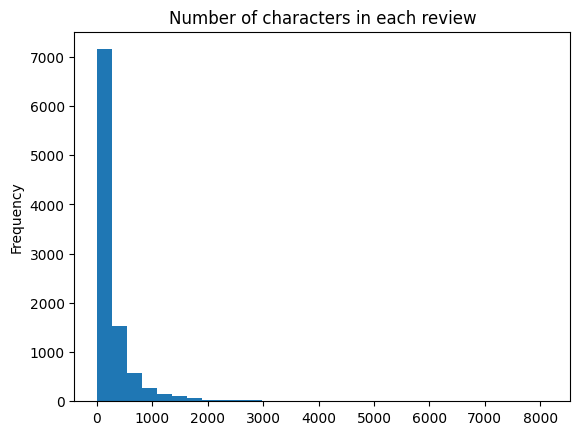

In [13]:
df_raw['num_chars'] = df_raw['text'].str.len()
df_raw['num_chars'].plot.hist(bins=30, title='Number of characters in each review')

Let's look at the number of words in each review:

In [14]:
# Let's check if this is the right method chain to extract the number of words
df_raw['text'].str.split().str.len()

0        19
1       101
2         4
3        14
4        63
       ... 
9995     11
9996     20
9997     41
9998      4
9999     54
Name: text, Length: 10000, dtype: int64

In [15]:
# Let's see if loc[2] is actually 4 words only
df_raw['text'].str.split().loc[2]

['أملاه', 'ابليس', 'وكتبه', 'ميكافيلي']

<Axes: title={'center': 'Number of words in each review'}, ylabel='Frequency'>

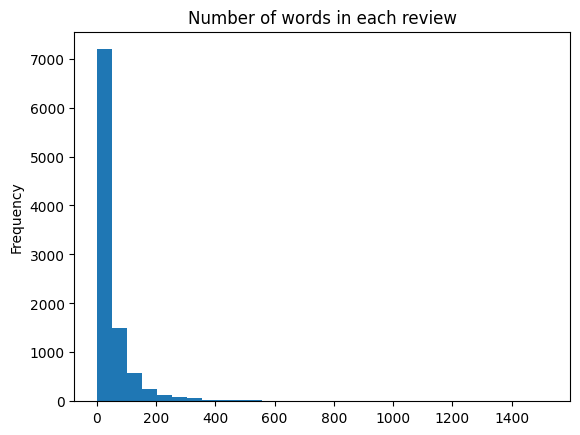

In [16]:
df_raw['num_words'] = df_raw['text'].str.split().str.len()
df_raw['num_words'].plot.hist(bins=30, title='Number of words in each review')

In [17]:
df_raw[['num_chars', 'num_words']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_chars,10000.0,301.6491,530.320618,3.0,69.0,144.0,309.0,8137.0
num_words,10000.0,55.7488,97.896935,1.0,13.0,26.0,57.0,1522.0


Observation: exponential distribution with most texts being less than 200 words.

Now we shall remove very long / very short texts:

> Note: we call it `df_normal` from now on to indicate the removal of outliers.

In [18]:
# Keep only the texts below the 90th percentile of the text lengths
df_normal = df_raw[df_raw['num_chars'] <= df_raw['num_chars'].quantile(0.9)]

<Axes: title={'center': 'Number of words in each review'}, ylabel='Frequency'>

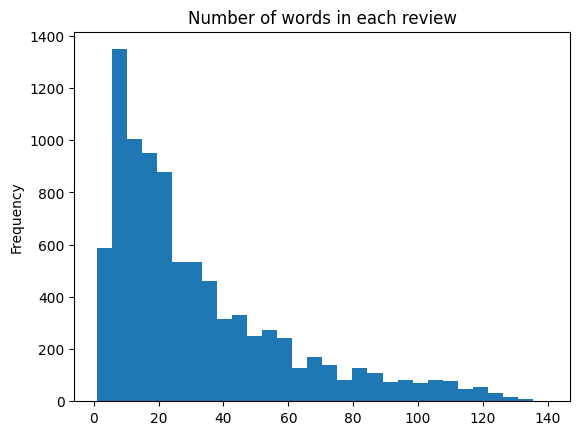

In [19]:
df_normal['num_words'].plot.hist(bins=30, title='Number of words in each review')

In [20]:
df_normal[['num_chars', 'num_words']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_chars,9005.0,175.247529,148.384721,3.0,64.0,126.0,244.0,667.0
num_words,9005.0,32.295614,27.643453,1.0,12.0,23.0,44.0,140.0


**Regular Expressions**'s key operations are:
- Match: Determine if a string matches a pattern.
- Find: Locate occurrences of a pattern within a string.
- Replace: Modify a string based on a pattern.
- Split: Divide a string into substrings using a pattern as a delimiter.

See the official [Regular Expression HOWTO](https://docs.python.org/3/howto/regex.html#regex-howto) for a user-friendly introductory tutorial on Regexes.

💡 **Tip**: when writing regexes, we recommended you always use an interactive realtime regex tester like: https://regex101.com/

In [21]:
import regex as re

# Twitter handles
user_pattern = r"@\w+"
hash_pattern = r"#\w+"

# start with https or start with www or end with .sa
url_pattern = r"https?\S+|www.\S+|\S+\.sa|\S+\.com"

def clean_text(x):
    x = re.sub(user_pattern, '', x)
    x = re.sub(hash_pattern, '', x)
    x = re.sub(url_pattern, '', x)
    return x

In [22]:
df_normal['text_clean'] = df_normal['text'].map(clean_text)

/tmp/ipykernel_1292624/1137305958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal['text_clean'] = df_normal['text'].map(clean_text)


After any deletion (cleaning), we might end up with empty texts. So let's make sure to remove that:

In [23]:

df_normal['text_clean'] = df_normal['text_clean'].str.strip()
df_normal = df_normal[df_normal['text_clean'].str.len() > 0]

/tmp/ipykernel_1292624/1769095702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal['text_clean'] = df_normal['text_clean'].str.strip()


In [24]:
# For reproducibility we want to check the same samples
# after any operation on text
sample_ids = df_normal.loc[45:55].index
sample_ids

Index([46, 47, 48, 49, 50, 51, 52, 53, 54, 55], dtype='int64')

In [25]:
df_normal[['text', 'text_clean']].loc[sample_ids]

,text,text_clean
46,اعتقد إن البهجة الوحيدة في الرواية دي هي الحقيقة اللي وصلها الشباب في الاخر أنهم لازم باختلاف تو...,اعتقد إن البهجة الوحيدة في الرواية دي هي الحقيقة اللي وصلها الشباب في الاخر أنهم لازم باختلاف تو...
47,مقبول ونرجوا التحسين . موقع. ازعاج في الغرف,مقبول ونرجوا التحسين . موقع. ازعاج في الغرف
48,هناك خيط رفيع بين الجرأة و الوقاحة فى الأدب .. و هو خيط لم يدركه الكاتب للأسف,هناك خيط رفيع بين الجرأة و الوقاحة فى الأدب .. و هو خيط لم يدركه الكاتب للأسف
49,ضعيف. الانترنت. الفندق,ضعيف. الانترنت. الفندق
50,جيد جدا. شكرا لكم.,جيد جدا. شكرا لكم.
51,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي محمود:. قد رأى المبصرون بعيون طه حسين مالم يروا بع...,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي محمود:. قد رأى المبصرون بعيون طه حسين مالم يروا بع...
52,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وحبيت الشخصيات,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وحبيت الشخصيات
53,جيد . الفدق جيد. الوقع. الاستقبال مركز الخدمة,جيد . الفدق جيد. الوقع. الاستقبال مركز الخدمة
54,تقييمي . . مكتوب من ضمن الخيارات تقديم مشروب مجاني وهذا لم يحدث وليس مهم المشروب ولكن المصداقية ...,تقييمي . . مكتوب من ضمن الخيارات تقديم مشروب مجاني وهذا لم يحدث وليس مهم المشروب ولكن المصداقية ...
55,ماكدونالدز انضم إلى المطاعم المستهترة بالزبون مع أن اسعارهم معقولة لكن غير صالح للأكل برأيي بحكم...,ماكدونالدز انضم إلى المطاعم المستهترة بالزبون مع أن اسعارهم معقولة لكن غير صالح للأكل برأيي بحكم...


### Normalizing Words

#### Text normalization techniques

- Lowercase -> `"Car" -> "car"`
- Longataion (التطويل):
    - "الــســلام عـــــــليكم"
- Extra characters denoting extra meaning (add `"!"` to it):
    - `"السلااااااام عليكم" -> "السلام! عليكم"`
    - `"loooooove" -> "love!"`
- Expand contractions (بسط الرموز):
    - Static:
        - `Don't -> Do not`
        - `4you -> for you` (Chat Slang)
    - Contextual: `I’d like to know how I’d done that!`
        - `I'd -> I would`
        - `I'd -> I had`
        - Checkout [pycontractions](https://pypi.org/project/pycontractions/)
- Convert Arabizi and Transliterated text into Arabic:
    - `6areeq / tareek -> طريق`
    - `6a3am / ta’am -> طعام`
    - `Fondoq / fondok -> فندق `
- Slice munged words
    - `heshotwhointhewhatnow -> ['he', 'shot', 'who', 'in', 'the', 'what', 'now']`
    - `thequickbrownfoxjumpsoverthelazydog -> ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']`
    - Checkout: [wordninja](https://github.com/keredson/wordninja)

[**PyArabic**](https://github.com/linuxscout/pyarabic) provides basic functions to manipulate Arabic letters and text, like detecting Arabic letters, Arabic letters groups and characteristics, remove diacritics etc.

In [26]:
def normalize_text(x):
    # remove punctuations
    x = re.sub(r'[^\w\s]', '', x)

    # remove extra whitespace
    x = re.sub(r'\s+', ' ', x)

    # remove elongations
    x = araby.strip_tatweel(x)
    
    return x

df_normal['text_clean'] = df_normal['text'].apply(normalize_text)
df_normal[['text', 'text_clean']].loc[sample_ids]

,text,text_clean
46,اعتقد إن البهجة الوحيدة في الرواية دي هي الحقيقة اللي وصلها الشباب في الاخر أنهم لازم باختلاف تو...,اعتقد إن البهجة الوحيدة في الرواية دي هي الحقيقة اللي وصلها الشباب في الاخر أنهم لازم باختلاف تو...
47,مقبول ونرجوا التحسين . موقع. ازعاج في الغرف,مقبول ونرجوا التحسين موقع ازعاج في الغرف
48,هناك خيط رفيع بين الجرأة و الوقاحة فى الأدب .. و هو خيط لم يدركه الكاتب للأسف,هناك خيط رفيع بين الجرأة و الوقاحة فى الأدب و هو خيط لم يدركه الكاتب للأسف
49,ضعيف. الانترنت. الفندق,ضعيف الانترنت الفندق
50,جيد جدا. شكرا لكم.,جيد جدا شكرا لكم
51,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي محمود:. قد رأى المبصرون بعيون طه حسين مالم يروا بع...,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي محمود قد رأى المبصرون بعيون طه حسين مالم يروا بعيو...
52,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وحبيت الشخصيات,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وحبيت الشخصيات
53,جيد . الفدق جيد. الوقع. الاستقبال مركز الخدمة,جيد الفدق جيد الوقع الاستقبال مركز الخدمة
54,تقييمي . . مكتوب من ضمن الخيارات تقديم مشروب مجاني وهذا لم يحدث وليس مهم المشروب ولكن المصداقية ...,تقييمي مكتوب من ضمن الخيارات تقديم مشروب مجاني وهذا لم يحدث وليس مهم المشروب ولكن المصداقية مهمه
55,ماكدونالدز انضم إلى المطاعم المستهترة بالزبون مع أن اسعارهم معقولة لكن غير صالح للأكل برأيي بحكم...,ماكدونالدز انضم إلى المطاعم المستهترة بالزبون مع أن اسعارهم معقولة لكن غير صالح للأكل برأيي بحكم...


Other libraries like [**tnkeeh (تنقيح)**](https://github.com/ARBML/tnkeeh) do exist for Arabic preprocessing of common examples.

#### Correct Typos

[**ekphrasis**](https://github.com/cbaziotis/ekphrasis): 

> Ekphrasis is a text processing tool, geared towards text from social networks, such as Twitter or Facebook. Ekphrasis performs tokenization, word normalization, **word segmentation** (for splitting hashtags) and **spell correction**, using word statistics from 2 big corpora (english Wikipedia, twitter - 330mil english tweets).

```python
from ekphrasis.classes.segmenter import Segmenter

# segmenter using the word statistics from english Wikipedia
seg_eng = Segmenter(corpus="english") 

# segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus="twitter")

words = ["exponentialbackoff", "gamedev", "retrogaming", "thewatercooler", "panpsychism"]
for w in words:
    print(w)
    print("(eng):", seg_eng.segment(w))
    print("(tw):", seg_tw.segment(w))
    print()
```

Output:

```
exponentialbackoff
(eng): exponential backoff
(tw): exponential back off

gamedev
(eng): gamedev
(tw): game dev

retrogaming
(eng): retrogaming
(tw): retro gaming

thewatercooler
(eng): the water cooler
(tw): the watercooler

panpsychism
(eng): panpsychism
(tw): pan psych is m
```

The Spell Corrector is based on [Peter Norvig's spell-corrector](http://norvig.com/spell-correct.html). Just like the segmentation algorithm, we utilize word statistics in order to find the most probable candidate. Besides the provided statistics, you can use your own.

```python
from ekphrasis.classes.spellcorrect import SpellCorrector
sp = SpellCorrector(corpus="english") 
print(sp.correct("korrect"))
```

Output:

```
> correct
```

Let's apply *Spell Correction*:

```python
spell_checker = SpellChecker(language='ar')

def correct_spelling(x):
    misspelled = spell_checker.unknown(x.split())
    for word in misspelled:
        corrected = spell_checker.correction(word)
        if corrected:
            x = x.replace(word, corrected)
    return x
```

**Note**: it actually introduced some errors, rather than fix them.

- "والشعور" -> "والشعوب"
- "لم استمع" -> "لم استسغ"


#### Stemming and Lemmatization

Both simplify words..

**Stemming** (تجريد), the **S**lasher, is a **S**imple, **S**peedy, **Statistical algorithm** that may result in under-stemming and over-stemming.

- Result: Often produces "stems" that aren't real words (e.g., "university" $\rightarrow$ "univers").
- Performance: So fast, but inaccurate.

**Lemmatization** (تصريف), the **L**inguist, is a **L**ookup in **L**ixicon (**Dictionary**) based on **L**anguage rules (**Grammar**).

- Result: Always produces a "lemma," which is a valid dictionary word (e.g., "better" $\rightarrow$ "good").
- Performance: Laid back, but more accurate.

Comparing Qalasadi Lemmatizer vs ISRI Stemmer:

In [27]:
from nltk.stem import ISRIStemmer
import qalsadi.lemmatizer

# ISRI: Arabic Stemming without a root dictionary
stemmer = ISRIStemmer()
lemmatizer = qalsadi.lemmatizer.Lemmatizer()

words = ["الوقت", "يلعبون", "التلامذة", "سيأكلونها"]

df_stem = pd.DataFrame(words, columns=['word'])
df_stem['stem'] = df_stem['word'].apply(lambda x: stemmer.stem(x))
df_stem['lemma'] = df_stem['word'].apply(lambda x: lemmatizer.lemmatize(x))
df_stem

,word,stem,lemma
0,الوقت,وقت,وقت
1,يلعبون,لعب,لعب
2,التلامذة,لمذ,تلميذ
3,سيأكلونها,أكلو,أكل


Giving the lemmatizer context produces a better result:

In [28]:
text = "يلعب التلامذة في الوقت الذي سيأكلونها فيه"
lemmatizer.lemmatize_text(text)

['لعب', 'تلميذ', 'في', 'وقت', 'الذي', 'أكل', 'في']

Let's tokenize the text:

- We will choose to stem the words (takes about 12 seconds), because we don't have much time
- Otherwise, we would have gone with lemmatization because it is more accurate: `use_lemmatizer=True`

In [29]:
def tokenization(x, use_lemmatizer=False):
    if use_lemmatizer:
        # lemmatize_text is used to be contextual (e.g., verb vs noun)
        # it returns a list of words (tokens)
        x = lemmatizer.lemmatize_text(x)
    else:
        x = araby.strip_tashkeel(x)
        x = araby.tokenize(x)
        x = [stemmer.stem(w) for w in x] # stemming individual words
    return x

df_normal['stemmed_tokens'] = df_normal['text_clean'].apply(lambda x: tokenization(x, use_lemmatizer=False))

In [30]:
# To demonstrate lemmatizer, we only apply to the first 2 rows
pd.DataFrame({
    'text': df_normal.loc[:2, 'text'],
    'lemma_tokens': df_normal.loc[:2, 'text_clean'].apply(lambda x: tokenization(x, use_lemmatizer=True)),
})

,text,lemma_tokens
0,كتاب كاريكاتورى يحارب الانظمه المستبده والحكام الطغاه والشعوب المستسلمه. الا اننى لم استسغ ابدا ...,"[كتاب, كاريكاتورى, حارب, الانظمه, المستبده, حاكم, الطغاه, شعب, المستسلمه, ال, اننى, لم, استساغ, ..."
1,من زمان مقرأتش كلمات بالروعة دي. منار وجدي بالرغم من أنها موهبة جديدة في عالم الكتب إلا أنها إست...,"[من, زمان, مقرأتش, لمة, روع, دي, منار, جدي, رغم, من, أن, موهبة, جديد, في, عالم, كتاب, إلا, أن, إ..."
2,أملاه ابليس وكتبه ميكافيلي,"[أمل, ابليس, تب, ميكافيلي]"


After cleaning, and tokenizing, now we can do stopwords removal.

Note, keeping words should give us more context and hence more information for a more accurate text classification. However, **we choose to remove them to reduce computation overhead on the model**. Less features mean reduced dimensionality and hence, less computation.

#### Stop words

[**Stop words**](https://en.wikipedia.org/wiki/Stop_word) are the words in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text) because they are deemed insignificant.

There is no single universal list of stop words used by all NLP tools, nor any agreed upon rules for identifying stop words, and indeed not all tools even use such a list. Therefore, any group of words can be chosen as the stop words for a given purpose. The "general trend in [information retrieval] systems over time has been from standard use of quite large stop lists (200–300 terms) to very small stop lists (7–12 terms) to no stop list whatsoever".

In [31]:
stopwords_ar = nltk.corpus.stopwords.words('arabic')

print(len(stopwords_ar)) # how many stop words?
print(stopwords_ar[:10]) # first 10 stop words

754
['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']


In [32]:
stopwords_ar.append('جميع') # add a custom stopword
stopwords_ar.append('السلام عليكم ورحمة الله وبركاته') # add a custom phrase

In [33]:
print(len(stopwords_ar)) # should be more now
print(stopwords_ar[-5:]) # last 5 stop words now

756
['كرب', 'كاد', 'هبّ', 'جميع', 'السلام عليكم ورحمة الله وبركاته']


In [34]:
def remove_stopwords(xs):
    return [w for w in xs if w not in stopwords_ar]

df_normal['stemmed_tokens'] = df_normal['stemmed_tokens'].apply(remove_stopwords)

In [35]:
df_normal.loc[sample_ids, ['text_clean', 'stemmed_tokens']]

,text_clean,stemmed_tokens
46,اعتقد إن البهجة الوحيدة في الرواية دي هي الحقيقة اللي وصلها الشباب في الاخر أنهم لازم باختلاف تو...,"[عقد, ان, بهج, وحد, روي, دي, حقق, الل, وصل, شبب, اخر, نهم, لزم, توج, تعو, عشن, بلد, دي, عدل, وير..."
47,مقبول ونرجوا التحسين موقع ازعاج في الغرف,"[نرج, تحس, وقع, زعج, غرف]"
48,هناك خيط رفيع بين الجرأة و الوقاحة فى الأدب و هو خيط لم يدركه الكاتب للأسف,"[خيط, رفع, جرأ, وقح, فى, ادب, خيط, يدر, كتب, اسف]"
49,ضعيف الانترنت الفندق,"[ضعف, نرن, ندق]"
50,جيد جدا شكرا لكم,"[جيد, جدا, شكر]"
51,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي محمود قد رأى المبصرون بعيون طه حسين مالم يروا بعيو...,"[رأي, كتب, جزئ, اول, قله, صطف, حمد, بصر, بعي, طه, حسن, الم, يرا, بعو, صطفى, حمد]"
52,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وحبيت الشخصيات,"[حبت, سلب, كتب, كتر, وفي, جزء, كبر, روح, وحب, شخص]"
53,جيد الفدق جيد الوقع الاستقبال مركز الخدمة,"[جيد, فدق, جيد, وقع, ركز, خدم]"
54,تقييمي مكتوب من ضمن الخيارات تقديم مشروب مجاني وهذا لم يحدث وليس مهم المشروب ولكن المصداقية مهمه,"[قيم, كتب, ضمن, خير, قدم, شرب, مجا, وهذا, حدث, وليس, مهم, شرب, صدق, همه]"
55,ماكدونالدز انضم إلى المطاعم المستهترة بالزبون مع أن اسعارهم معقولة لكن غير صالح للأكل برأيي بحكم...,"[ماكدونالدز, نضم, الى, طعم, هتر, زبن, ان, سعر, عقل, صلح, اكل, برأ, حكم, انه, سنو, خير, كثر, زبن,..."


### Morphological Tokenization

Morphological tokenization whereby Arabic words are split into component prefixes, stems, and suffixes.

- Input Tokens: `['فتنفست', 'الصعداء']`
- Output: split morphologically and apply diacritics: `['فَ+', 'تَنَفَّسْتُ', 'ال+', 'صُعَداءَ']`

[CAMeL Tools](https://github.com/CAMeL-Lab/camel_tools) is suite of Arabic natural language processing tools developed by the CAMeL Lab at New York University Abu Dhabi.

See the [CAMeL Tools Guided Tour](https://colab.research.google.com/drive/1Y3qCbD6Gw1KEw-lixQx1rI6WlyWnrnDS?usp=sharing#scrollTo=KmeKhpPVsI69); Morphological Tokenization.

#### Install CAMeL Tools Data

CAMeL Tools requires additional data files for morphological analysis. We install the "light" version for this lab.


In [36]:
# %pip install camel-tools

In [37]:
# install just the datasets for morphology and MLE disambiguation only
# !camel_data -i light

In [38]:
# The tokenizer expects pre-tokenized text
sentence = simple_word_tokenize('فتنفست الصعداء')
print(sentence)

# Load a pretrained disambiguator to use with a tokenizer
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# We can output diacritized tokens by setting `diac=True`
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok',
                                   split=True, # split affixes
                                   diac=True,  # diacritize
                                   )
tokens = tokenizer.tokenize(sentence)
print(tokens)

['فتنفست', 'الصعداء']


['فَ+', 'تَنَفَّسَت', 'ال+', 'صُعَداءَ']


In [39]:
def tokenize_morph(x):
    x = simple_word_tokenize(x)
    return tokenizer.tokenize(x)

# Due to processing time, we only demonstrate it
print(df_normal.loc[:5, 'text_clean'].apply(tokenize_morph).apply(lambda xs: ' '.join(xs)).str.cat(sep='\n'))

كِتابِ كارِيكاتُورِ +ِي يُحارِب ال+ أَنْظِمَة ال+ مُسْتَبِدَّة وَ+ ال+ حُكّامِ ال+ طُغاة وَ+ ال+ شُعُوبِ المستسلمه إِلّا أَنَّ +نِي لَمْ استسغ أَبَداً فِكْرَةَ جَمْعِ ال+ كارِيكاتِير فِي كِتابِ
مِن زَمانٍ مقرأتش كَلِماتٌ بِ+ ال+ رَوْعَة دِي مَنار وَ+ جَدْي بِ+ ال+ رَغْمِ مِن أَنَّ +ها مَوْهِبَةَ جَدِيدَةٍ فِي عالَمِ ال+ كُتُبِ إِلّا أَنَّ +ها اِسْتَطاعَت بِ+ بَراعَةٍ إِثْباتِ مَدَى رَوْعَةِ مَوْهَبَة +ها فِي عالَمِ ال+ كِتابَةِ كاتِبَةٍ مُتَمَيِّزَةٍ جِدّاً مُتَحَكِّم +هُ جِدّاً فِي أَدَو واثِقَةً جِدّاً مِن كَلِم أَحْياناً أَشْعُر أَنَّ +ها بتسخر أَنْقَى وَ+ أَرْوَع ال+ كَلِماتُ لِ+ خِدْمَةِ خَيال +ها كِتابِ حَلْقَةِ وَصَلَ مِن ال+ كُتُبِ ال+ لَيّ هقراها تَأَنِّي أَنا عِنْد +نِي لَيِسَت فِي +ها كَتَبَ مُعَيَّن +هُ بِ+ قُرَى +ها تَأَنِّي وَ+ تَأَلَّت وَ+ حَلْقَة وَصَلَ مِن +هُم أَكِيد أُسْلُوبِ +هُ ال+ مُتَمَيِّزِ جِدّاً وَ+ فِكْرَةِ أَظْهار ال+ قِصَّةِ مِن وِجْهَةِ نَظَرِ طَرَفَيْ +ها فِكْرَةَ ال+ فَواصِل ال+ شِعْرِيَّةُ بَيِّنَ ال+ سَرْد لِ+ جَذْبِ ال+ NOAN وَ+ لا أَرْوَع كِتابِ رائِ

**Note**: to make the tutorial light and quick, we will not use **morphological tokenization** (it is computationally heavy). However, we think it is much more accurate to do such tokenization than simple *lemmatizers* or *stemmers*.

### Save the cleaned data

In [40]:
df_normal

,label,text,num_chars,num_words,text_clean,stemmed_tokens
0,Negative,كتاب كاريكاتورى يحارب الانظمه المستبده والحكام الطغاه والشعوب المستسلمه. الا اننى لم استسغ ابدا ...,124,19,كتاب كاريكاتورى يحارب الانظمه المستبده والحكام الطغاه والشعوب المستسلمه الا اننى لم استسغ ابدا ف...,"[كتب, كاريكاتورى, حرب, ظمه, بده, حكم, طغه, شعب, سلم, الا, ننى, سسغ, ابد, فكر, جمع, كاريكاتير, فى..."
1,Positive,من زمان مقرأتش كلمات بالروعة دي. منار وجدي بالرغم من أنها موهبة جديدة في عالم الكتب إلا أنها إست...,564,101,من زمان مقرأتش كلمات بالروعة دي منار وجدي بالرغم من أنها موهبة جديدة في عالم الكتب إلا أنها إستط...,"[زمن, مقرأتش, كلم, روع, دي, نار, رغم, انه, جدد, كتب, الا, انه, طاع, برع, اثب, مدى, روع, كتب, كتب..."
2,Mixed,أملاه ابليس وكتبه ميكافيلي,26,4,أملاه ابليس وكتبه ميكافيلي,"[مله, بلس, كتب, ميكافيلي]"
3,Positive,كتاب رائع لن تستطيع ان تتركه الا وقد انهيته. سهرت حتي الفجر لاكمل قرائته,72,14,كتاب رائع لن تستطيع ان تتركه الا وقد انهيته سهرت حتي الفجر لاكمل قرائته,"[كتب, رئع, تطع, ان, تتر, الا, وقد, سهر, حتي, فجر, كمل, قرت]"
4,Mixed,رواية أخرى متعددة الرواة من نجيب محفوظ. اعجبتني الفكرة العامة وكون الرواية من طبقات مع كل شخصية ...,360,63,رواية أخرى متعددة الرواة من نجيب محفوظ اعجبتني الفكرة العامة وكون الرواية من طبقات مع كل شخصية ن...,"[روي, خرى, تعدد, روة, نجب, حفظ, عجب, فكر, عمة, وكن, روي, طبق, شخص, كتشف, زيد, سرر, كتشف, فرق, سر..."
...,...,...,...,...,...,...
9995,Negative,حاجة مقرفة .. لو فى تقيم ب السالب كنت عملت :,44,11,حاجة مقرفة لو فى تقيم ب السالب كنت عملت,"[حجة, قرف, فى, تقم, سلب, كنت, عمل]"
9996,Mixed,مقبول. . الانترنت ضعيف ومتقطع عمال الفندق يطرقون الباب طرقتين ثم يدخلون حتى لو لم تأذن لهم وهي ق...,102,20,مقبول الانترنت ضعيف ومتقطع عمال الفندق يطرقون الباب طرقتين ثم يدخلون حتى لو لم تأذن لهم وهي قلة أدب,"[نرن, ضعف, تقطع, عمل, ندق, طرق, باب, طرق, دخل, تأذ, وهي, قلة, ادب]"
9997,Positive,ما زلت أتذكر شعوري بالحماسة والدهشة أثناء قراءتها . ولا زلت أتذكر تفاصيل هذه الرواية رغم مرور عد...,213,41,ما زلت أتذكر شعوري بالحماسة والدهشة أثناء قراءتها ولا زلت أتذكر تفاصيل هذه الرواية رغم مرور عدة ...,"[زلت, ذكر, شعر, حمس, دهش, ثنء, قرء, زلت, ذكر, فصل, روي, رغم, رور, عدة, سنو, قرء, ادر, اذا, سيك, ..."
9998,Mixed,رسومات و كلمات رقيقة..,22,4,رسومات و كلمات رقيقة,"[رسم, كلم, رقق]"


In [41]:
df_normal.to_csv('ar_reviews_100k_cleaned.tsv', sep='\t', index=False)

## Key Takeaways

- **Data acquisition** from external sources (like Kaggle) requires proper authentication and data extraction techniques.

- **Exploratory Data Analysis (EDA)** is essential before preprocessing to understand:
  - Class distribution (balanced vs. imbalanced datasets)
  - Text length distributions (identifying outliers)
  - Language detection (ensuring expected language)
  - Vocabulary characteristics (size, frequency patterns)
  - Class-specific word patterns

- **Data splitting** must occur before preprocessing to prevent data leakage from test set to training set.

- **Preprocessing order matters critically**:
  1. Extract structured information (URLs, handles, hashtags)
  2. Normalize text (remove elongations, diacritics)
  3. Tokenize
  4. Stem/Lemmatize
  5. Remove stop words last
 
- **Preprocessing trade-offs** exist between:
  - Speed vs. accuracy (stemming vs. lemmatization)
  - Simple models needs simple features and vice-versa (stop words removal)
  - Vocabulary size vs. computational cost

- Understanding your data through EDA guides preprocessing decisions and helps build effective NLP pipelines for Arabic text classification.